# Zindi Covid-19 Contest - Data Prep

This notebook shows how the data for the Zindi contest - Predicting the Global Spread of COVID-19 is derived. As this is an evolving situation, the dataset is not fixed at the start of the contest. Instead, you may use all available data at a given time, and are encouraged to keep incorporating new data as it becomes available. Each week, the leaderboard wil reset and a new submission file will be shared covering the most recent test period. The ultimate goal is to make predictions fo the time following the CLOSE of the competition - more info on the competition page.

In this notebook, we download the latest figures from https://github.com/CSSEGISandData/COVID-19, add some additional information, group by Country/Region, re-shape into the format required for submission and show how you can score your model on the latest data without needing to upload submissions to Zindi. 

## Downloading the Data

The data has been curated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE), and is pubically available on their GitHub repository. We clone the repository to get the data.


In [1]:
# Get the latest data

# !git clone https://github.com/CSSEGISandData/COVID-19

## Loading the Data

In [2]:
import pandas as pd

In [3]:
cases = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
cases.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,273,281,299,349,367,423,444,484,521,555
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,277,304,333,361,377,383,400,409,416,433
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,986,1171,1251,1320,1423,1468,1572,1666,1761,1825
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,428,439,466,501,525,545,564,583,601,601
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,8,8,10,14,16,17,19,19,19,19


In [4]:
deaths = pd.read_csv('./COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
deaths.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


# Adding All Countries 

To avoid changing the submission format, Zindi are now using a set list of countries. This section will be updated as new Countries/Regions are added to the JHU data, to try and maintain a consistent mapping.

In [5]:
# Download a list of countries from the UN
# !curl -o EF.xlsx https://untermportal.un.org/unterm/country/downloadfile?targetLanguage=fr

In [6]:
countries = pd.read_excel('EF.xlsx')[:193]
countries.head(2)

,English short,French short,English formal,French formal
0,Afghanistan,Afghanistan (l'),the Islamic Republic of Afghanistan,la République islamique d'Afghanistan
1,Albania,Albanie (l'),the Republic of Albania,la République d'Albanie


In [7]:
# Which regions in the JHU data have direct matches in countries?
print(deaths.shape, deaths['Country/Region'].unique().shape)
print(deaths.loc[deaths['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique().shape)

(264, 85) (185,)
(152,)


In [8]:
# For those with direct matches, add a new column ['Territory']
deaths['Territory'] = ''
for c in deaths.loc[deaths['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique():
  deaths.loc[deaths['Country/Region'] == c, 'Territory'] = c

# Same for cases
cases['Territory'] = ''
for c in cases.loc[cases['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique():
  cases.loc[cases['Country/Region'] == c, 'Territory'] = c

deaths.loc[deaths['Country/Region']=='Taiwan*', 'Territory'] = 'Taiwan'
cases.loc[cases['Country/Region']=='Taiwan*', 'Territory'] = 'Taiwan'

In [9]:
# The problem ones we need to reconcile manually:
print(deaths.loc[~deaths['Country/Region'].isin(countries['English short'].values)]['Country/Region'].unique())

['Bahamas' 'Bolivia' 'Brunei' 'Central African Republic'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' "Cote d'Ivoire"
 'Diamond Princess' 'Dominican Republic' 'Gambia' 'Holy See' 'Iran'
 'Korea, South' 'Moldova' 'Netherlands' 'Niger' 'Philippines' 'Russia'
 'Sudan' 'Taiwan*' 'Tanzania' 'United Arab Emirates' 'United Kingdom' 'US'
 'Venezuela' 'Vietnam' 'Syria' 'Laos' 'West Bank and Gaza' 'Kosovo'
 'Burma' 'MS Zaandam' 'Western Sahara']


In [10]:
# Add them manually:
deaths.loc[deaths['Country/Region'] == 'United Arab Emirates', 'Territory'] = 'United Arab Emirates (the)'
deaths.loc[deaths['Country/Region'] == 'Philippines', 'Territory'] = 'Philippines (the)'
deaths.loc[deaths['Country/Region'] == 'Dominican Republic', 'Territory'] = 'Dominican Republic (the)'
deaths.loc[deaths['Country/Region'] == 'Brunei', 'Territory'] = 'Brunei Darussalam'
deaths.loc[deaths['Country/Region'] == 'US', 'Territory'] = 'United States of America (the)'
deaths.loc[deaths['Country/Region'] == 'Iran', 'Territory'] = 'Iran (Islamic Republic of)'
deaths.loc[deaths['Country/Region'] == 'Korea, South', 'Territory'] = "Democratic People's Republic of Korea (the)" # IS this right?
deaths.loc[deaths['Country/Region'] == 'Vietnam', 'Territory'] = 'Viet Nam'
deaths.loc[deaths['Country/Region'] == 'Russia', 'Territory'] = 'Russian Federation (the)'
deaths.loc[deaths['Country/Region'] == 'Moldova', 'Territory'] = 'Republic of Moldova (the)'
deaths.loc[deaths['Country/Region'] == 'Bolivia', 'Territory'] = 'Bolivia (Plurinational State of)'
deaths.loc[deaths['Country/Region'] == 'United Kingdom', 'Territory'] = 'United Kingdom of Great Britain and Northern Ireland (the)'
deaths.loc[deaths['Country/Region'] == 'Congo (Kinshasa)', 'Territory'] = 'Democratic Republic of the Congo (the)' # <<< Please check
deaths.loc[deaths['Country/Region'] == "Cote d'Ivoire", 'Territory'] = "Côte d'Ivoire"
deaths.loc[deaths['Country/Region'] == 'Sudan', 'Territory'] = "South Sudan" #?
deaths.loc[deaths['Country/Region'] == 'Venezuela', 'Territory'] = "Venezuela (Bolivarian Republic of)"
deaths.loc[deaths['Country/Region'] == 'Central African Republic', 'Territory'] = 'Central African Republic (the)'
deaths.loc[deaths['Country/Region'] == 'Congo (Brazzaville)', 'Territory'] = 'Congo (the)'
deaths.loc[deaths['Country/Region'] == 'Netherlands', 'Territory'] = 'Netherlands (the)'
deaths.loc[deaths['Country/Region'] == 'Tanzania', 'Territory'] = 'United Republic of Tanzania (the)'
deaths.loc[deaths['Country/Region'] == 'Gambia', 'Territory'] = 'Gambia (the)'
deaths.loc[deaths['Country/Region'] == 'Bahamas', 'Territory'] = 'Bahamas (the)'
deaths.loc[deaths['Country/Region'] == 'Niger', 'Territory'] = 'Niger (the)'
deaths.loc[deaths['Country/Region'] == 'Syria', 'Territory'] = 'Syrian Arab Republic (the)'
deaths.loc[deaths['Country/Region'] == 'Laos', 'Territory'] = "Lao People's Democratic Republic (the)"

# Drop those without a country match (!! - check output to make sure we aren't missing new additions)
print('Dropping', deaths.loc[deaths['Territory'] == '']['Country/Region'].unique())
print(deaths.shape)
deaths=deaths.loc[deaths['Territory']!= '']
print(deaths.shape)

# And for cases
# Add them manually:
cases.loc[cases['Country/Region'] == 'United Arab Emirates', 'Territory'] = 'United Arab Emirates (the)'
cases.loc[cases['Country/Region'] == 'Philippines', 'Territory'] = 'Philippines (the)'
cases.loc[cases['Country/Region'] == 'Dominican Republic', 'Territory'] = 'Dominican Republic (the)'
cases.loc[cases['Country/Region'] == 'Brunei', 'Territory'] = 'Brunei Darussalam'
cases.loc[cases['Country/Region'] == 'US', 'Territory'] = 'United States of America (the)'
cases.loc[cases['Country/Region'] == 'Iran', 'Territory'] = 'Iran (Islamic Republic of)'
cases.loc[cases['Country/Region'] == 'Korea, South', 'Territory'] = "Democratic People's Republic of Korea (the)" # IS this right?
cases.loc[cases['Country/Region'] == 'Vietnam', 'Territory'] = 'Viet Nam'
cases.loc[cases['Country/Region'] == 'Russia', 'Territory'] = 'Russian Federation (the)'
cases.loc[cases['Country/Region'] == 'Moldova', 'Territory'] = 'Republic of Moldova (the)'
cases.loc[cases['Country/Region'] == 'Bolivia', 'Territory'] = 'Bolivia (Plurinational State of)'
cases.loc[cases['Country/Region'] == 'United Kingdom', 'Territory'] = 'United Kingdom of Great Britain and Northern Ireland (the)'
cases.loc[cases['Country/Region'] == 'Congo (Kinshasa)', 'Territory'] = 'Democratic Republic of the Congo (the)' # <<< Please check
cases.loc[cases['Country/Region'] == "Cote d'Ivoire", 'Territory'] = "Côte d'Ivoire"
cases.loc[cases['Country/Region'] == 'Sudan', 'Territory'] = "South Sudan" #?
cases.loc[cases['Country/Region'] == 'Venezuela', 'Territory'] = "Venezuela (Bolivarian Republic of)"
cases.loc[cases['Country/Region'] == 'Central African Republic', 'Territory'] = 'Central African Republic (the)'
cases.loc[cases['Country/Region'] == 'Congo (Brazzaville)', 'Territory'] = 'Congo (the)'
cases.loc[cases['Country/Region'] == 'Netherlands', 'Territory'] = 'Netherlands (the)'
cases.loc[cases['Country/Region'] == 'Tanzania', 'Territory'] = 'United Republic of Tanzania (the)'
cases.loc[cases['Country/Region'] == 'Gambia', 'Territory'] = 'Gambia (the)'
cases.loc[cases['Country/Region'] == 'Bahamas', 'Territory'] = 'Bahamas (the)'
cases.loc[cases['Country/Region'] == 'Niger', 'Territory'] = 'Niger (the)'
cases.loc[cases['Country/Region'] == 'Syria', 'Territory'] = 'Syrian Arab Republic (the)'
cases.loc[cases['Country/Region'] == 'Laos', 'Territory'] = "Lao People's Democratic Republic (the)"

# Drop those without a country match (!! - check output to make sure we aren't missing new additions)
print('Dropping', cases.loc[cases['Territory'] == '']['Country/Region'].unique())
print(cases.shape)
cases=cases.loc[cases['Territory']!= '']
print(cases.shape)

Dropping ['Diamond Princess' 'Holy See' 'West Bank and Gaza' 'Kosovo' 'Burma'
 'MS Zaandam' 'Western Sahara']
(264, 86)
(257, 86)
Dropping ['Diamond Princess' 'Holy See' 'West Bank and Gaza' 'Kosovo' 'Burma'
 'MS Zaandam' 'Western Sahara']
(264, 86)
(257, 86)


In [11]:
# Add the rest of the countries with cases set to 0 (!! Use with caution as data may be unreported)
import numpy as np

remainder = countries.loc[~countries['English short'].isin(deaths.Territory.unique())]
print('Adding:', remainder['English short'].unique())
for c in remainder['English short'].unique():
  row = pd.Series([0 for _ in range(len(deaths.columns))])
  row_df = pd.DataFrame([row])
  row_df.columns = deaths.columns
  row_df['Country/Region'] = c
  row_df['Territory'] = c
  deaths = pd.concat([deaths, row_df], ignore_index=True)
print(deaths.shape)

# And for cases
for c in remainder['English short'].unique():
  row = pd.Series([0 for _ in range(len(cases.columns))])
  row_df = pd.DataFrame([row])
  row_df.columns = cases.columns
  row_df['Country/Region'] = c
  row_df['Territory'] = c
  cases = pd.concat([cases, row_df], ignore_index=True)
print(cases.shape)

Adding: ['Comoros (the)' 'Kiribati' 'Lesotho' 'Marshall Islands (the)'
 'Micronesia (Federated States of)' 'Myanmar' 'Nauru' 'Palau'
 'Republic of Korea (the)' 'Samoa' 'Solomon Islands' 'Sudan (the)'
 'Tajikistan' 'Tonga' 'Turkmenistan' 'Tuvalu' 'Vanuatu']
(274, 86)
(274, 86)


# Splitting out some regions into their own territories

Some regions are listed as part of one country, but due to geography or politics can be considered a separate entity. Without getting too political, let's separate out a few of these.

In [12]:
# Taiwan, St. Martin, Faroe Islands, St. Barthelemy, French Polynesia, French Guiana, Mayotte, Guadeloupe, Curacao, Cayman Islands, Reunion, Aruba, monserrat, Greenland, new caledonia, Bermuda.
for r in ['St Martin', 'Faroe Islands', 'Saint Barthelemy', 'French Polynesia', 'French Guiana', 'Mayotte',
          'Guadeloupe', 'Curacao', 'Cayman Islands', 'Reunion', 'Aruba', 'Montserrat', 'Greenland', 'New Caledonia', 'Bermuda']:
  if deaths.loc[deaths['Province/State']==r].shape[0]<1:
    print(r)
  deaths.loc[deaths['Province/State']==r, 'Territory'] = r
  cases.loc[cases['Province/State']==r, 'Territory'] = r


## Adding Population info

This is optional, but this section adds population info. Use with caution, and feel free to make manual corrections. 

In [13]:
# !pip install countryinfo # Run if needed

In [14]:
from countryinfo import CountryInfo

pops = {}
fails = []

regions = sorted(deaths['Territory'].unique())
for r in regions:
  try:
    country = CountryInfo(r)
    pops[r] = country.info()['population']
  except:
    fails.append(r)
    print('No pop data for', r)

No pop data for Andorra
No pop data for Bahamas (the)
No pop data for Bolivia (Plurinational State of)
No pop data for Brunei Darussalam
No pop data for Cabo Verde
No pop data for Central African Republic (the)
No pop data for Comoros (the)
No pop data for Congo (the)
No pop data for Curacao
No pop data for Czechia
No pop data for Côte d'Ivoire
No pop data for Democratic People's Republic of Korea (the)
No pop data for Democratic Republic of the Congo (the)
No pop data for Dominican Republic (the)
No pop data for Eswatini
No pop data for Gambia (the)
No pop data for Iran (Islamic Republic of)
No pop data for Lao People's Democratic Republic (the)
No pop data for Marshall Islands (the)
No pop data for Micronesia (Federated States of)
No pop data for Montenegro
No pop data for Myanmar
No pop data for Netherlands (the)
No pop data for Niger (the)
No pop data for North Macedonia
No pop data for Philippines (the)
No pop data for Republic of Korea (the)
No pop data for Republic of Moldova (t

In [15]:
# Manual fixes
# As you can see, this missed many territories, but is provided as a starting point. You can manually add or source better datasets.

In [16]:
# Adding in population as a column
cols = list(deaths.columns)
deaths['Population'] = deaths['Country/Region'].map(pops)
deaths = deaths[cols[:2]+['Territory','Population']+cols[2:-1]] # Better ordering
deaths.head()

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,Afghanistan,26023100.0,33.0000,65.0000,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,Albania,2895947.0,41.1533,20.1683,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,Algeria,38700000.0,28.0339,1.6596,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,Andorra,NaN,42.5063,1.5218,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,Angola,24383301.0,-11.2027,17.8739,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [17]:

deaths[deaths['Population'].isnull()]

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
3,NaN,Andorra,Andorra,NaN,42.506300,1.521800,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
18,NaN,Bahamas,Bahamas (the),NaN,25.034300,-77.396300,0,0,0,0,...,1,1,4,4,5,6,7,8,8,8
26,NaN,Bolivia,Bolivia (Plurinational State of),NaN,-16.290200,-63.588700,0,0,0,0,...,8,9,10,10,11,14,15,18,19,20
29,NaN,Brunei,Brunei Darussalam,NaN,4.535300,114.727700,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
32,NaN,Cabo Verde,Cabo Verde,NaN,16.538800,-23.041800,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
46,NaN,Central African Republic,Central African Republic (the),NaN,6.611100,20.939400,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,NaN,Congo (Brazzaville),Congo (the),NaN,-4.038300,21.758700,0,0,0,0,...,2,2,2,5,5,5,5,5,5,5
84,NaN,Congo (Kinshasa),Democratic Republic of the Congo (the),NaN,-4.038300,21.758700,0,0,0,0,...,13,13,18,18,18,18,18,18,20,20
86,NaN,Cote d'Ivoire,Côte d'Ivoire,NaN,7.540000,-5.547100,0,0,0,0,...,1,1,1,3,3,3,3,3,3,4
90,NaN,Czechia,Czechia,NaN,49.817500,15.473000,0,0,0,0,...,44,53,59,67,78,88,99,112,119,129


In [18]:
from collections import Counter

c = len(deaths['Territory'])
print(c)

274


In [19]:
deaths.describe()

,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
count,2.190000e+02,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,...,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,2.326267e+08,19.945929,20.805750,0.062044,0.065693,0.094891,0.153285,0.204380,0.299270,0.478102,...,193.310219,214.492701,235.729927,253.131387,272.076642,298.708029,322.321168,348.295620,374.087591,395.905109
std,4.874236e+08,24.674516,69.361558,1.027008,1.028562,1.451957,2.417550,3.142847,4.592341,7.551622,...,1192.573175,1299.837302,1406.454790,1494.182052,1591.096875,1725.978952,1847.995143,1983.674744,2124.261238,2248.562710
min,1.008400e+04,-51.796300,-135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.185779e+06,2.675700,-14.998400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.588890e+07,19.584785,17.776500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,6.607800e+07,40.051825,68.739750,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,10.750000,12.000000,13.000000,15.750000,18.000000,19.000000,20.750000,21.000000,22.750000,23.000000
max,1.367110e+09,71.706900,178.065000,17.000000,17.000000,24.000000,40.000000,52.000000,76.000000,125.000000,...,13915.000000,14681.000000,15362.000000,15887.000000,16523.000000,17127.000000,17669.000000,18279.000000,18849.000000,20463.000000


## Some Quick Visualizations

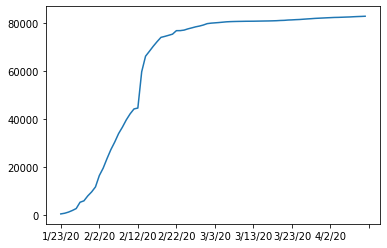

In [20]:
# Cases for mainland China (note - data is cumulative)
cases.groupby('Territory').sum().loc['China'][3:].plot()

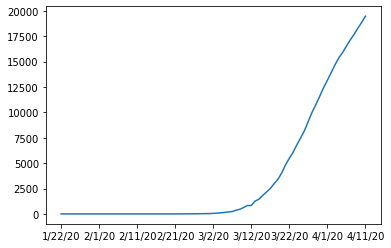

In [21]:
# Deaths in Italy
deaths.groupby('Territory').sum().loc['Italy'][3:].plot()

In [22]:
# Looking at raw numbers vs pop adjusted figures
grouped = deaths.groupby('Territory').sum()
# grouped['3/12/20'].sort_values(ascending=False).head(20) # Raw numbers
(grouped['3/12/20']*1e7/deaths.groupby('Territory').mean()['Population']).sort_values(ascending=False).head(20) # Scaled by population (deaths/10M people)

Territory
San Marino     916.226369
Italy          136.088896
China           23.202230
Guyana          12.740574
Spain           11.825983
Lebanon          7.309942
France           7.264142
Switzerland      4.887705
Albania          3.453102
Panama           2.693014
Belgium          2.672494
Iraq             2.221941
Ireland          1.567890
Bulgaria         1.380133
Australia        1.265988
Japan            1.259049
Austria          1.172714
Sweden           1.026955
Greece           0.909704
Germany          0.371365
dtype: float64

## Preparing a 'sample submission' file and scoring locally

This will mimic the way submissions to Zindi will work. We'll generate an example submission file along with a reference file (the correct answers, used for scoring). 

Dates for the submission will change as the competition goes on. Here, we'll use the last available week of data for local testing. The next section shows how to create a submission file that can be uploaded to Zindi for scoring.

In [23]:
# Creating the 'reference' file

TEST_PERIOD = 7 # In days

test_dates = deaths.columns[-TEST_PERIOD:] # The last two weeks worth of data
countries = deaths.groupby('Territory').sum()[test_dates] # Group by country/region, and select only the columns for the test_period

# Create a new dataframe, with a Region X Date column. 
reference = pd.DataFrame({
    'Territory X Date':list(map((lambda x: ' X '.join(x)), list(countries.stack().index.to_flat_index()))), # Check output to see what this is doing
    'target':countries.stack() # The target we'll be predicting: cumulative number of cases for a given region at a given date.
}).reset_index(drop=True) # Don't need the multiIndex created with Stack
reference.to_csv('reference.csv', index=False)
reference.head()

,Territory X Date,target
0,Afghanistan X 4/5/20,7
1,Afghanistan X 4/6/20,11
2,Afghanistan X 4/7/20,14
3,Afghanistan X 4/8/20,14
4,Afghanistan X 4/9/20,15


In [24]:
# Sample submission is the same as the reference file, just with target set to 0
print(reference.target.sum())
ss = reference.copy()
ss['target'] = 0
print(ss.target.sum())
ss.to_csv('SampleSubLocal.csv', index=False)

620480
0


In [25]:
# Scoring
from sklearn.metrics import mean_absolute_error

# Create some 'predictions
predictions = ss.copy()
predictions['target'] = 42 # These would be your actual predictions

# Calculate MAE
print('MAE: ', mean_absolute_error(reference['target'], predictions['target']))

MAE:  437.768967874231


# Matching the Zindi Submission File

The competition requires that you submit a file containing predictions for the whole of the time period between March 6 and June 7. The way it works is that only the relevant week's worth of predictions will be evaluated. Let's create an appropriate file.

In [26]:
dates = pd.date_range(start='2020-03-06', end='2020-06-07', freq='1d')
ids = []
for c in sorted(deaths['Territory'].unique()):
  for d in dates:
    ids.append(c + ' X ' + d.strftime('%m/%d/%y'))
ss = pd.DataFrame({
    'Territory X Date':ids,
    'target':0
})
ss.to_csv('SampleSubmission.csv', index=False)
ss.head()

,Territory X Date,target
0,Afghanistan X 03/06/20,0
1,Afghanistan X 03/07/20,0
2,Afghanistan X 03/08/20,0
3,Afghanistan X 03/09/20,0
4,Afghanistan X 03/10/20,0


In [27]:
ss.tail()

,Territory X Date,target
19641,Zimbabwe X 06/03/20,0
19642,Zimbabwe X 06/04/20,0
19643,Zimbabwe X 06/05/20,0
19644,Zimbabwe X 06/06/20,0
19645,Zimbabwe X 06/07/20,0


# Creating 'Train.csv'

You can shape your training data in any way you want, **provided that it does not include data from the test period**. The goal is to predict into the future. While the competition is open, you could simply use all the available data for training and get a near-perfect score. However, this won't represent how well your model will do in the future. The final score will be based on new, unseen data based on events after the competition closes. 

This is how the 'train.csv' file available from Zindi is generated:

In [28]:
train_dates = deaths.columns[6:-TEST_PERIOD] # The dates for the train perion

# Grouping by territory
country_deaths = deaths.groupby('Territory').sum()[train_dates] 
country_cases = cases.groupby('Territory').sum()[train_dates] 

# Creating the dataframe
train = pd.DataFrame({
    'Territory X Date':list(map((lambda x: ' X '.join(x)), list(country_deaths.stack().index.to_flat_index()))), 
    'target':country_deaths.stack(),
    'cases':country_cases.stack() # Added as they may be useful
}).reset_index(drop=True)

# Add Separate Region and Date columns
train['Territory'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[0])
train['Date'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[1])

# Saving and viewing
train.to_csv('train.csv', index=False)
train.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20


In [29]:
# Add Separate Region and Date columns
train['Territory'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[0])
train['Date'] = train['Territory X Date'].apply(lambda x: x.split(' X ')[1])
train.head()

,Territory X Date,target,cases,Territory,Date
0,Afghanistan X 1/22/20,0,0,Afghanistan,1/22/20
1,Afghanistan X 1/23/20,0,0,Afghanistan,1/23/20
2,Afghanistan X 1/24/20,0,0,Afghanistan,1/24/20
3,Afghanistan X 1/25/20,0,0,Afghanistan,1/25/20
4,Afghanistan X 1/26/20,0,0,Afghanistan,1/26/20


In [30]:
train.to_csv('train.csv', index=False)

In [31]:
deaths.head()

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,Afghanistan,26023100.0,33.0000,65.0000,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,Albania,2895947.0,41.1533,20.1683,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,Algeria,38700000.0,28.0339,1.6596,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,Andorra,NaN,42.5063,1.5218,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,Angola,24383301.0,-11.2027,17.8739,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


# Deal with missing population data

In [39]:
#dataset from kaggle https://www.kaggle.com/nightranger77/covid19-demographic-predictors

covid_by_country = pd.read_csv('covid19_by_country.csv')
covid_by_country.head()

,Country,Tests,Test Pop,Density,Urban Pop,Quarantine,Schools,Restrictions,Hospital Bed,sex0,...,Male Lung,Median Age,GDP 2018,Crime Index,Population 2020,Smoking 2016,Females 2018,Total Infected,Total Deaths,Total Recovered
0,Albania,NaN,NaN,105.0,63.0,NaN,NaN,NaN,2.9,1.08,...,17.04,32.9,1.510250e+10,40.02,2877.797,28.7,49.063095,446,23,217
1,Algeria,NaN,NaN,18.0,73.0,NaN,NaN,NaN,1.9,1.05,...,12.81,28.1,1.737580e+11,54.41,43851.044,15.6,49.484268,1914,293,591
2,Argentina,NaN,NaN,17.0,93.0,3/20/2020,NaN,NaN,5.0,1.05,...,42.59,31.7,5.198715e+11,62.96,45195.774,21.8,51.237348,2142,90,468
3,Armenia,694.0,4269.802594,104.0,63.0,NaN,NaN,NaN,4.2,1.13,...,35.99,35.1,1.243309e+10,20.78,2963.243,24.1,52.956577,1013,13,197
4,Australia,31635.0,806.065560,3.0,86.0,NaN,NaN,3/23/2020,3.8,1.06,...,22.16,38.7,1.433904e+12,42.70,25499.884,14.7,50.199623,6315,60,1806


In [45]:
#viewing columns of dataset above that have null values
covid_by_country.isnull().sum()

Country             0
Tests              49
Test Pop           49
Density             0
Urban Pop           0
Quarantine         81
Schools            81
Restrictions       82
Hospital Bed        0
sex0                0
sex14               0
sex25               0
sex54               0
sex64               0
sex65plus           0
Sex Ratio           1
lung                0
Female Lung         0
Male Lung           0
Median Age          0
GDP 2018            0
Crime Index         0
Population 2020     0
Smoking 2016        0
Females 2018        0
Total Infected      0
Total Deaths        0
Total Recovered     0
dtype: int64

In [46]:
#Crime and Population data https://worldpopulationreview.com/countries/crime-rate-by-country/
total_pop = pd.read_csv('pop.csv')
total_pop.head()

,Rank,name,pop2020,pop2019,GrowthRate,area,Density
0,1,China,1439323.776,1433783.686,1.0039,9706961.0,147.7068
1,2,India,1380004.385,1366417.754,1.0099,3287590.0,415.6290
2,3,United States,331002.651,329064.917,1.0059,9372610.0,35.1092
3,4,Indonesia,273523.615,270625.568,1.0107,1904569.0,142.0928
4,5,Pakistan,220892.340,216565.318,1.0200,881912.0,245.5634


In [51]:
#selecting rows where the population cell is NaN
deaths[deaths['Population'].isnull()]

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
3,NaN,Andorra,Andorra,NaN,42.506300,1.521800,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
18,NaN,Bahamas,Bahamas (the),NaN,25.034300,-77.396300,0,0,0,0,...,1,1,4,4,5,6,7,8,8,8
26,NaN,Bolivia,Bolivia (Plurinational State of),NaN,-16.290200,-63.588700,0,0,0,0,...,8,9,10,10,11,14,15,18,19,20
29,NaN,Brunei,Brunei Darussalam,NaN,4.535300,114.727700,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
32,NaN,Cabo Verde,Cabo Verde,NaN,16.538800,-23.041800,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
46,NaN,Central African Republic,Central African Republic (the),NaN,6.611100,20.939400,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83,NaN,Congo (Brazzaville),Congo (the),NaN,-4.038300,21.758700,0,0,0,0,...,2,2,2,5,5,5,5,5,5,5
84,NaN,Congo (Kinshasa),Democratic Republic of the Congo (the),NaN,-4.038300,21.758700,0,0,0,0,...,13,13,18,18,18,18,18,18,20,20
86,NaN,Cote d'Ivoire,Côte d'Ivoire,NaN,7.540000,-5.547100,0,0,0,0,...,1,1,1,3,3,3,3,3,3,4
90,NaN,Czechia,Czechia,NaN,49.817500,15.473000,0,0,0,0,...,44,53,59,67,78,88,99,112,119,129


In [82]:
#using this to fill countries with null population in our dataset
total_pop[total_pop['name']=='Russia']


,Rank,name,pop2020,pop2019,GrowthRate,area,Density
8,9,Russia,145934.462,145872.256,1.0004,17098242.0,8.5314


In [93]:
# Create new column using dictionary

missing_population = {'Andorra':77265,'Bahamas (the)':393244,'Bolivia (Plurinational State of)':11673021,'Brunei Darussalam':436567,'Cabo Verde':555987,
 'Central African Republic (the)':4829767,'Comoros (the)':869601,'Congo (the)':88935316,'Curacao':164093,'Czechia':10704687,
 "Côte d'Ivoire":26230299,"Democratic People's Republic of Korea (the)":25795136,'Democratic Republic of the Congo (the)':88935316,'Dominican Republic (the)':10824494,'Eswatini':1157543,
 'Gambia (the)':2401338,'Iran (Islamic Republic of)':83992949,"Lao People's Democratic Republic (the)":7251699,'Marshall Islands (the)':59104,'Micronesia (Federated States of)':547718,
 'Montenegro':628066,'Myanmar':544098,'Netherlands (the)':17134872,'Niger (the)':24206644,'North Macedonia':2083374,
 'Philippines (the)':109581078,'Republic of Korea (the)':51259914,'Republic of Moldova (the)':4033963,'Reunion':895312,'Russian Federation (the)':145934462,
 'Saint Barthelemy':9871,'Sao Tome and Principe':219159,'Serbia':8737371,'St Martin':38520,'Sudan (the)':42813238,'Syrian Arab Republic (the)':17500658,
'Timor-Leste':1312841,'United Arab Emirates (the)':9864540,'United Kingdom of Great Britain and Northern Ireland (the)':67530172,'United Republic of Tanzania (the)':59734218,
'United States of America (the)':330589397,'Venezuela (Bolivarian Republic of)':28435940,'Viet Nam':97338579}

In [94]:
deaths.head()

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,Afghanistan,26023100.0,33.0000,65.0000,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,Albania,2895947.0,41.1533,20.1683,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,Algeria,38700000.0,28.0339,1.6596,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,Andorra,NaN,42.5063,1.5218,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,Angola,24383301.0,-11.2027,17.8739,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [101]:
#create new dataframe that will contain the entire population filled
deaths_pop = deaths.copy()

# combine this new population data with existing DataFrame 
for i, j in missing_population.items():
    deaths_pop.loc[deaths_pop['Territory'] == i, ['Population']] = j
    
deaths_pop.head()

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,Afghanistan,26023100.0,33.0000,65.0000,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,Albania,2895947.0,41.1533,20.1683,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,Algeria,38700000.0,28.0339,1.6596,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,Andorra,77265.0,42.5063,1.5218,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,Angola,24383301.0,-11.2027,17.8739,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [104]:
deaths_pop[deaths_pop['Population'].isnull()]
#looks like there are still 6 rows that have no population data

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
164,Aruba,Netherlands,Aruba,NaN,12.5186,-70.0358,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201,NaN,Sudan,South Sudan,NaN,12.8628,30.2176,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
205,NaN,Taiwan*,Taiwan,NaN,23.7000,121.0000,0,0,0,0,...,5,5,5,5,5,5,5,5,6,6
215,Bermuda,United Kingdom,Bermuda,NaN,32.3078,-64.7505,0,0,0,0,...,0,0,0,0,2,2,3,4,4,4
216,Cayman Islands,United Kingdom,Cayman Islands,NaN,19.3133,-81.2546,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
220,Montserrat,United Kingdom,Montserrat,NaN,16.7425,-62.1874,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
final_missing_pop = {'Aruba':106664,'South Sudan':11164991,'Taiwan':23807695,'Bermuda':62326,'Cayman Islands':65555,'Montserrat':4991}

In [106]:
for i, j in final_missing_pop.items():
    deaths_pop.loc[deaths_pop['Territory'] == i, ['Population']] = j
    
deaths_pop.head()

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20
0,NaN,Afghanistan,Afghanistan,26023100.0,33.0000,65.0000,0,0,0,0,...,6,6,7,7,11,14,14,15,15,18
1,NaN,Albania,Albania,2895947.0,41.1533,20.1683,0,0,0,0,...,16,17,20,20,21,22,22,23,23,23
2,NaN,Algeria,Algeria,38700000.0,28.0339,1.6596,0,0,0,0,...,86,105,130,152,173,193,205,235,256,275
3,NaN,Andorra,Andorra,77265.0,42.5063,1.5218,0,0,0,0,...,15,16,17,18,21,22,23,25,26,26
4,NaN,Angola,Angola,24383301.0,-11.2027,17.8739,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2


In [107]:
deaths_pop[deaths_pop['Population'].isnull()]
#popultion data filled!

,Province/State,Country/Region,Territory,Population,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,...,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20


# Adding Area Km2

In [109]:
country_area = {}
fails_area = []

regions = sorted(deaths_pop['Territory'].unique())
for r in regions:
  try:
    country = CountryInfo(r)
    pops[r] = country.info()['area']
  except:
    fails.append(r)
    print('No area per km2 data for', r)

No area per km2 data for Andorra
No area per km2 data for Bahamas (the)
No area per km2 data for Bolivia (Plurinational State of)
No area per km2 data for Brunei Darussalam
No area per km2 data for Cabo Verde
No area per km2 data for Central African Republic (the)
No area per km2 data for Comoros (the)
No area per km2 data for Congo (the)
No area per km2 data for Curacao
No area per km2 data for Czechia
No area per km2 data for Côte d'Ivoire
No area per km2 data for Democratic People's Republic of Korea (the)
No area per km2 data for Democratic Republic of the Congo (the)
No area per km2 data for Dominican Republic (the)
No area per km2 data for Eswatini
No area per km2 data for Gambia (the)
No area per km2 data for Iran (Islamic Republic of)
No area per km2 data for Lao People's Democratic Republic (the)
No area per km2 data for Marshall Islands (the)
No area per km2 data for Micronesia (Federated States of)
No area per km2 data for Montenegro
No area per km2 data for Myanmar
No area 

In [ ]:
# Adding in population as a column
cols = list(deaths.columns)
deaths['Population'] = deaths['Country/Region'].map(pops)
deaths = deaths[cols[:2]+['Territory','Population']+cols[2:-1]] # Better ordering
deaths.head()